## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage import interpolation
import math
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold

## Load Data

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

## utility function

### graph

In [3]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

### alphabet image

In [4]:
def digit_image(x):
    return np.where(x>=150, x, 0)

### alphabet one-hot encoding

In [5]:
def alpha_one_hot(x):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False)
    
    integer_encoded = label_encoder.fit_transform(x)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    
    x = onehot_encoder.fit_transform(integer_encoded)
    return x

### Deskew

In [6]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [7]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [8]:
def deskew_all(image_data):
    deskewed = []
    
    for i in range(len(image_data)):
        deskewed.append(deskew(image_data[i].reshape(28,28)))
    
    return np.array(deskewed)[:,:,:,np.newaxis]

## EDA

In [9]:
train

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,...,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,...,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,...,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,...,2,3,1,1,0,4,1,4,3,1


In [10]:
test

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,P,1,2,1,1,0,0,0,2,...,0,1,3,0,3,0,4,3,1,4
20476,22525,S,4,1,1,4,0,0,1,1,...,1,3,1,0,0,1,3,1,2,0
20477,22526,B,4,2,1,3,2,1,3,0,...,3,2,3,4,1,0,3,3,1,1
20478,22527,K,1,1,2,3,4,0,4,3,...,2,0,0,4,3,3,3,4,4,2


In [11]:
pd.value_counts(train['letter'])

Z    91
O    90
K    90
L    89
H    89
G    87
Y    86
M    86
U    85
Q    82
T    82
R    81
F    80
X    79
N    77
D    76
S    76
C    74
V    73
A    72
B    71
W    69
J    67
E    66
P    66
I    64
Name: letter, dtype: int64

In [12]:
X_temp = np.array(train[[str(i) for i in range(784)]][:32])
X_temp = X_temp.reshape(-1,1,28,28)
X_temp.shape

(32, 1, 28, 28)

In [13]:
train_digit = train['digit'].values
X_train_letter = train['letter'].values
X_test_letter = test['letter'].values

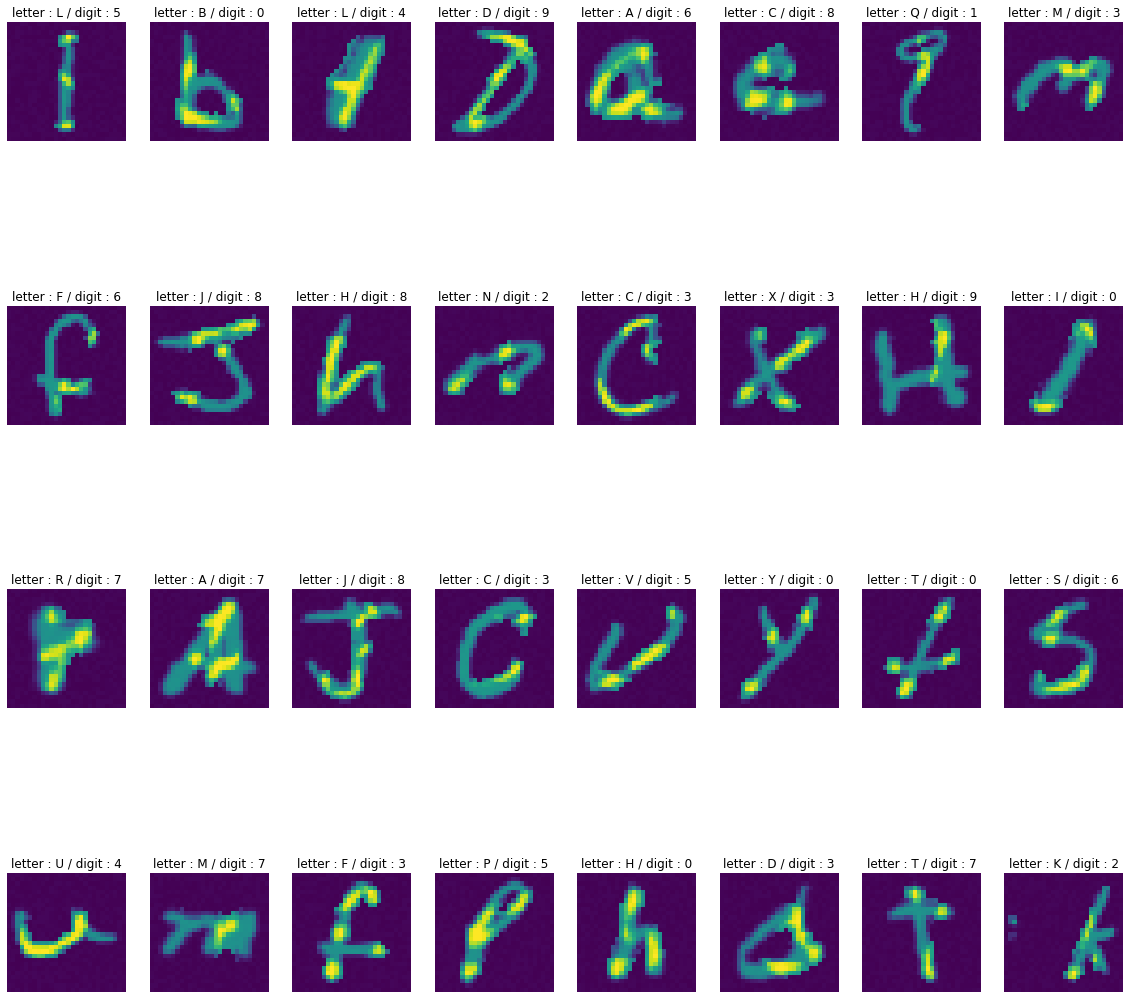

In [14]:
plt.figure(figsize=(20,20))
for idx, (image, digit, letter) in enumerate(zip(X_temp[:32], train_digit[:32] ,X_train_letter[:32])):
    plt.subplot(4,8,idx+1)
    plt.imshow(image[0])
    title = 'letter : {} / digit : {}'.format(letter, digit)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

## Dataset 

In [15]:
X_train = train.drop(['letter','id','digit'],axis=1)
X_test = test.drop(['letter','id'],axis=1)

In [16]:
X_trains = X_train.values.reshape(-1,28,28,1).astype(float)
X_test = X_test.values.reshape(-1,28,28,1).astype(float)

In [17]:
X_trains.shape

(2048, 28, 28, 1)

In [18]:
X_test.shape

(20480, 28, 28, 1)

In [19]:
X_trains = deskew_all(X_trains)
X_test = deskew_all(X_test)

In [20]:
y_trains = train['digit']

In [21]:
y_trains = utils.to_categorical(y_trains, 10)

In [22]:
y_trains.shape

(2048, 10)

In [23]:
X_train_digit = digit_image(X_trains)
X_test_digit = digit_image(X_test)

In [24]:
X_train_alpha = X_trains - X_train_digit/2
X_test_alpha = X_test - X_test_digit/2

In [25]:
X_trains = np.concatenate((X_trains, X_train_digit, X_train_alpha),axis=-1)
X_test = np.concatenate((X_test, X_test_digit, X_test_alpha),axis=-1)

In [26]:
X_trains.shape

(2048, 28, 28, 3)

In [27]:
X_test.shape

(20480, 28, 28, 3)

## Train

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Input, Flatten, Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [29]:
reduction_ratio=16

In [30]:
def rexnet():    
    input_ = tf.keras.layers.Input(shape=(28,28,3))
    letter = tf.keras.layers.Input(shape=(26))

    conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                                  kernel_constraint=tf.keras.constraints.max_norm(3.))(input_) #28x28x128


    ## Residual Unit1
    batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
    elu1_1 = tf.keras.layers.ELU()(batch1_1)
    res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_1) 
    batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
    elu1_2 = tf.keras.layers.ELU()(batch1_2)
    res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_2) 
    batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
    elu1_3 = tf.keras.layers.ELU()(batch1_3)
    res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_3)                          

    # SEBlock1
    ch_input1 = 128
    ch_reduced1 = ch_input1//reduction_ratio
    avpool1 = tf.keras.layers.GlobalAveragePooling2D()(res1_3)
    sed1_1 = tf.keras.layers.Dense(ch_reduced1, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool1)
    sed1_2 = tf.keras.layers.Dense(ch_input1, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed1_1)
    reshape1 = tf.keras.layers.Reshape((1,1,ch_input1))(sed1_2)
    mul1 = tf.keras.layers.Multiply()([res1_3, reshape1])
    #

    skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
    res1 = tf.keras.layers.Add()([mul1, skip1]) #28x28x128
    ##

    ## Residual Unit2
    batch2_1 = tf.keras.layers.BatchNormalization()(res1)
    elu2_1 = tf.keras.layers.ELU()(batch2_1)
    res2_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_1) 
    batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
    elu2_2 = tf.keras.layers.ELU()(batch2_2)
    res2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_2) 
    batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
    elu2_3 = tf.keras.layers.ELU()(batch2_3)
    res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_3)                         


    # SEBlock2
    ch_input2 = 128
    ch_reduced2 = ch_input2//reduction_ratio
    avpool2 = tf.keras.layers.GlobalAveragePooling2D()(res2_3)
    sed2_1 = tf.keras.layers.Dense(ch_reduced2, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool2)
    sed2_2 = tf.keras.layers.Dense(ch_input2, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed2_1)
    reshape2 = tf.keras.layers.Reshape((1,1,ch_input2))(sed2_2)
    mul2 = tf.keras.layers.Multiply()([res2_3, reshape2])
    #
    skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(res1)
    res2 = tf.keras.layers.Add()([mul2, skip2])
    drop2 = tf.keras.layers.Dropout(0.3)(res2) # 28x28x128
    ##


    ## Residual Unit3
    batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
    elu3_1 = tf.keras.layers.ELU()(batch3_1)
    res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_1) 
    batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
    elu3_2 = tf.keras.layers.ELU()(batch3_2)
    res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_2) 
    batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
    elu3_3 = tf.keras.layers.ELU()(batch3_3)
    res3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_3)                           


    # SEBlock3
    ch_input3 = 128
    ch_reduced3 = ch_input3//reduction_ratio
    avpool3 = tf.keras.layers.GlobalAveragePooling2D()(res3_3)
    sed3_1 = tf.keras.layers.Dense(ch_reduced3, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool3)
    sed3_2 = tf.keras.layers.Dense(ch_input3, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed3_1)
    reshape3 = tf.keras.layers.Reshape((1,1,ch_input3))(sed3_2)
    mul3 = tf.keras.layers.Multiply()([res3_3, reshape3])
    #
    skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
    res3 = tf.keras.layers.Add()([mul3, skip3]) #28x28x128
    ##


    ## Residual Unit4
    batch4_1 = tf.keras.layers.BatchNormalization()(res3)
    elu4_1 = tf.keras.layers.ELU()(batch4_1)
    res4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_1) 
    batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
    elu4_2 = tf.keras.layers.ELU()(batch4_2)
    res4_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_2) 
    batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
    elu4_3 = tf.keras.layers.ELU()(batch4_3)
    res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_3)                              


    # SEBlock4
    ch_input4 = 256
    ch_reduced4 = ch_input4//reduction_ratio
    avpool4 = tf.keras.layers.GlobalAveragePooling2D()(res4_3)
    sed4_1 = tf.keras.layers.Dense(ch_reduced4, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool4)
    sed4_2 = tf.keras.layers.Dense(ch_input4, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed4_1)
    reshape4 = tf.keras.layers.Reshape((1,1,ch_input4))(sed4_2)
    mul4 = tf.keras.layers.Multiply()([res4_3, reshape4])
    #
    skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res3)
    res4 = tf.keras.layers.Add()([mul4, skip4])
    pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
    drop4 = tf.keras.layers.Dropout(0.3)(pool4) # 14x14x256
    ##


    ## Residual Unit5
    batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
    elu5_1 = tf.keras.layers.ELU()(batch5_1)
    res5_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_1) 
    batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
    elu5_2 = tf.keras.layers.ELU()(batch5_2)
    res5_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_2) 
    batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
    elu5_3 = tf.keras.layers.ELU()(batch5_3)
    res5_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_3)                                 


    # SEBlock5
    ch_input5 = 256
    ch_reduced5 = ch_input5//reduction_ratio
    avpool5 = tf.keras.layers.GlobalAveragePooling2D()(res5_3)
    sed5_1 = tf.keras.layers.Dense(ch_reduced5, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool5)
    sed5_2 = tf.keras.layers.Dense(ch_input5, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed5_1)
    reshape5 = tf.keras.layers.Reshape((1,1,ch_input5))(sed5_2)
    mul5 = tf.keras.layers.Multiply()([res5_3, reshape5])
    #
    skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
    res5 = tf.keras.layers.Add()([mul5, skip5])
    pool5 = tf.keras.layers.MaxPool2D((2,2))(res5) #7x7x256
    ##


    ## Residual Unit6
    batch6_1 = tf.keras.layers.BatchNormalization()(pool5)
    elu6_1 = tf.keras.layers.ELU()(batch6_1)
    res6_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_1) 
    batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
    elu6_2 = tf.keras.layers.ELU()(batch6_2)
    res6_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_2) 
    batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
    elu6_3 = tf.keras.layers.ELU()(batch6_3)
    res6_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_3)
    # SEBlock6
    ch_input6 = 256
    ch_reduced6 = ch_input6//reduction_ratio
    avpool6 = tf.keras.layers.GlobalAveragePooling2D()(res6_3)
    sed6_1 = tf.keras.layers.Dense(ch_reduced6, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool6)
    sed6_2 = tf.keras.layers.Dense(ch_input6, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed6_1)
    reshape6 = tf.keras.layers.Reshape((1,1,ch_input6))(sed6_2)
    mul6 = tf.keras.layers.Multiply()([res6_3, reshape6])
    #
    skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool5)
    res6 = tf.keras.layers.Add()([mul6, skip6])
    drop6 = tf.keras.layers.Dropout(0.3)(res6) # 7x7x256
    ##

    ## Residual Unit7
    batch7_1 = tf.keras.layers.BatchNormalization()(drop6)
    elu7_1 = tf.keras.layers.ELU()(batch7_1)
    res7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_1) 
    batch7_2 = tf.keras.layers.BatchNormalization()(res7_1)
    elu7_2 = tf.keras.layers.ELU()(batch7_2)
    res7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_2) 
    batch7_3 = tf.keras.layers.BatchNormalization()(res7_2)
    elu7_3 = tf.keras.layers.ELU()(batch7_3)
    res7_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_3)
    skip7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop6)
    res7 = tf.keras.layers.Add()([res7_3, skip7])
    pool7 = tf.keras.layers.MaxPool2D((3,3))(res7) # 2x2x512


    flatten1 = tf.keras.layers.Flatten()(pool7)
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    # gap = tf.keras.layers.GlobalAveragePooling2D()(pool7)
    # dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(gap)

    drop10 = tf.keras.layers.Dropout(0.2)(dense1)
    output = tf.keras.layers.Dense(10 ,activation='softmax')(drop10)
    
    model = Model(inputs= [input_], outputs=[output])
    
    return model

In [31]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [32]:
valid_datagen = ImageDataGenerator(
    rescale=1./255)

In [33]:
epochs=500
batch_size = 32
n_fold = 10

In [34]:
# k_fold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=2020)

In [35]:
sk_fold = StratifiedKFold(n_splits=n_fold, shuffle=False, random_state=2020)

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


model_0
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 53ms/step - loss: 5.0300 - accuracy: 0.1212 - val_loss: 3.1803 - val_accuracy: 0.1198 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 43ms/step - loss: 2.4568 - accuracy: 0.1629 - val_loss: 3.1108 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 3s 45ms/step - loss: 2.4637 - accuracy: 0.1673 - val_loss: 2.9489 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 41ms/step - loss: 2.3549 - accuracy: 0.1828 - val_loss: 3.8793 - val_accuracy: 0.1198 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 45ms/step - loss: 2.3367 - accuracy: 0.1988 - val_loss: 2.9902 - val_accuracy: 0.1823 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 45ms/step - loss: 2.2524 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 40ms/step - loss: 1.2748 - accuracy: 0.5621 - val_loss: 1.1603 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 39ms/step - loss: 1.2438 - accuracy: 0.5820 - val_loss: 1.9394 - val_accuracy: 0.4896 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 38ms/step - loss: 1.2634 - accuracy: 0.5721 - val_loss: 1.6080 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 38ms/step - loss: 1.2647 - accuracy: 0.5781 - val_loss: 1.2362 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 39ms/step - loss: 1.2181 - accuracy: 0.6030 - val_loss: 0.9504 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 3s 45ms/step - loss: 1.1402 - accuracy: 0.6168 - val_loss: 0.8063 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 41ms/st

57/57 [==============================] - 2s 41ms/step - loss: 0.9133 - accuracy: 0.6996 - val_loss: 0.7063 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9599 - accuracy: 0.6853 - val_loss: 0.9864 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9573 - accuracy: 0.6919 - val_loss: 0.6861 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 40ms/step - loss: 0.9108 - accuracy: 0.7035 - val_loss: 0.6362 - val_accuracy: 0.8021 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 3s 45ms/step - loss: 0.9094 - accuracy: 0.6996 - val_loss: 0.7112 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 3s 45ms/step - loss: 0.9358 - accuracy: 0.6930 - val_loss: 0.8122 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 41ms/step - lo

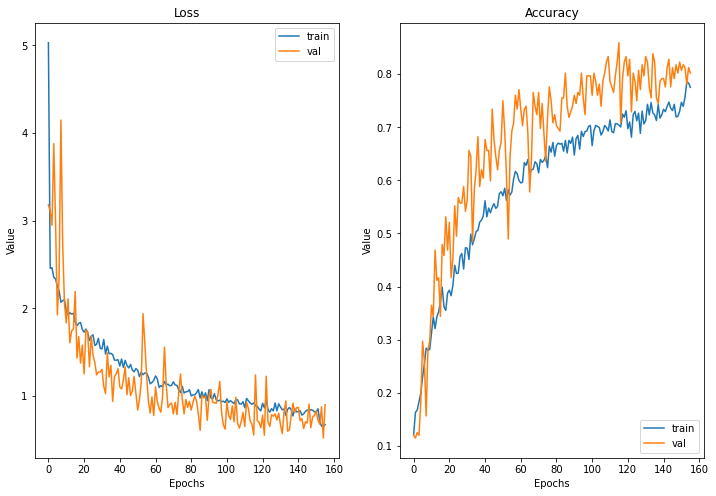

model_1
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 53ms/step - loss: 4.8669 - accuracy: 0.1124 - val_loss: 2.3682 - val_accuracy: 0.1094 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 3s 45ms/step - loss: 2.4765 - accuracy: 0.1463 - val_loss: 2.8849 - val_accuracy: 0.1354 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 3s 46ms/step - loss: 2.4267 - accuracy: 0.1701 - val_loss: 2.3034 - val_accuracy: 0.2552 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 42ms/step - loss: 2.3696 - accuracy: 0.1861 - val_loss: 2.4040 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 45ms/step - loss: 2.2757 - accuracy: 0.2115 - val_loss: 2.2878 - val_accuracy: 0.2865 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 46ms/step - loss: 2.2119 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 40ms/step - loss: 1.2412 - accuracy: 0.5881 - val_loss: 0.8764 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2426 - accuracy: 0.5787 - val_loss: 0.8423 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2056 - accuracy: 0.5947 - val_loss: 1.4461 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2750 - accuracy: 0.5809 - val_loss: 1.0239 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2339 - accuracy: 0.5975 - val_loss: 0.9864 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 40ms/step - loss: 1.1677 - accuracy: 0.6218 - val_loss: 0.7323 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 41ms/st

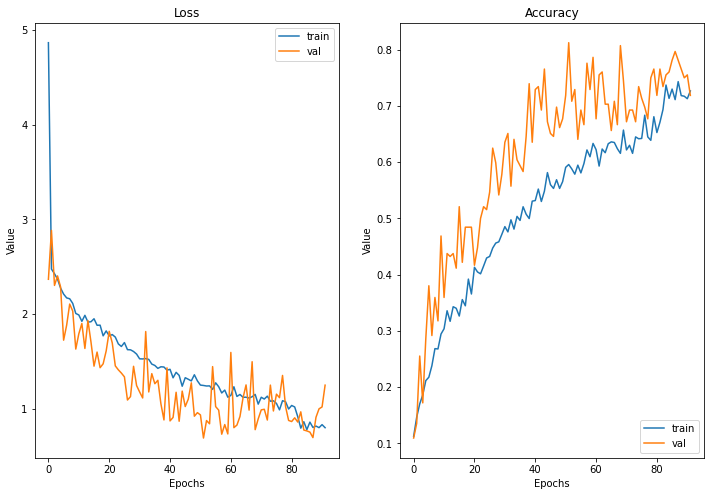

model_2
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 54ms/step - loss: 4.5802 - accuracy: 0.1184 - val_loss: 2.3472 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 44ms/step - loss: 2.4271 - accuracy: 0.1734 - val_loss: 2.8716 - val_accuracy: 0.1406 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 2s 42ms/step - loss: 2.3975 - accuracy: 0.1695 - val_loss: 3.8950 - val_accuracy: 0.1458 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 3s 46ms/step - loss: 2.2577 - accuracy: 0.2060 - val_loss: 2.0229 - val_accuracy: 0.2760 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 2s 41ms/step - loss: 2.2709 - accuracy: 0.2203 - val_loss: 2.9420 - val_accuracy: 0.1979 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 47ms/step - loss: 2.2228 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 43ms/step - loss: 1.2920 - accuracy: 0.5616 - val_loss: 1.1195 - val_accuracy: 0.6302 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 42ms/step - loss: 1.2767 - accuracy: 0.5699 - val_loss: 1.2552 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2077 - accuracy: 0.5886 - val_loss: 1.1706 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 3s 47ms/step - loss: 1.2319 - accuracy: 0.5814 - val_loss: 0.9585 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 42ms/step - loss: 1.2740 - accuracy: 0.5842 - val_loss: 0.9948 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 42ms/step - loss: 1.2156 - accuracy: 0.5908 - val_loss: 1.0281 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 42ms/st

57/57 [==============================] - 2s 41ms/step - loss: 0.7922 - accuracy: 0.7361 - val_loss: 1.0936 - val_accuracy: 0.7292 - lr: 7.0000e-04
Epoch 106/500
57/57 [==============================] - 2s 42ms/step - loss: 0.8292 - accuracy: 0.7112 - val_loss: 1.1274 - val_accuracy: 0.7396 - lr: 7.0000e-04
Epoch 107/500
57/57 [==============================] - 2s 42ms/step - loss: 0.8248 - accuracy: 0.7294 - val_loss: 1.0318 - val_accuracy: 0.7292 - lr: 7.0000e-04
Epoch 108/500
57/57 [==============================] - 2s 44ms/step - loss: 0.7978 - accuracy: 0.7338 - val_loss: 1.0852 - val_accuracy: 0.7344 - lr: 7.0000e-04
Epoch 109/500
57/57 [==============================] - 2s 40ms/step - loss: 0.8117 - accuracy: 0.7272 - val_loss: 1.0428 - val_accuracy: 0.7500 - lr: 7.0000e-04
Epoch 110/500
57/57 [==============================] - 2s 43ms/step - loss: 0.7827 - accuracy: 0.7261 - val_loss: 0.7910 - val_accuracy: 0.7917 - lr: 7.0000e-04
Epoch 111/500
57/57 [===========================

Epoch 156/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5415 - accuracy: 0.8161 - val_loss: 1.0193 - val_accuracy: 0.7917 - lr: 4.9000e-04
Epoch 157/500
57/57 [==============================] - 2s 40ms/step - loss: 0.5914 - accuracy: 0.7891 - val_loss: 1.1289 - val_accuracy: 0.7656 - lr: 4.9000e-04
Epoch 158/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5271 - accuracy: 0.8227 - val_loss: 1.0846 - val_accuracy: 0.7552 - lr: 4.9000e-04
Epoch 159/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5377 - accuracy: 0.8189 - val_loss: 0.8709 - val_accuracy: 0.7917 - lr: 4.9000e-04
Epoch 160/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5263 - accuracy: 0.8178 - val_loss: 0.8541 - val_accuracy: 0.7865 - lr: 4.9000e-04
Epoch 161/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5452 - accuracy: 0.8167 - val_loss: 1.0769 - val_accuracy: 0.7812 - lr: 4.9000e-04
Epoch 162/500
57/57 [=============

Epoch 207/500
57/57 [==============================] - 2s 40ms/step - loss: 0.3986 - accuracy: 0.8669 - val_loss: 0.8785 - val_accuracy: 0.7917 - lr: 3.4300e-04
Epoch 208/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4039 - accuracy: 0.8680 - val_loss: 0.8391 - val_accuracy: 0.8333 - lr: 3.4300e-04
Epoch 209/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4294 - accuracy: 0.8498 - val_loss: 0.7361 - val_accuracy: 0.8333 - lr: 3.4300e-04
Epoch 210/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4030 - accuracy: 0.8620 - val_loss: 1.1805 - val_accuracy: 0.7865 - lr: 3.4300e-04
Epoch 211/500
57/57 [==============================] - 2s 41ms/step - loss: 0.4367 - accuracy: 0.8564 - val_loss: 0.6544 - val_accuracy: 0.8438 - lr: 3.4300e-04
Epoch 212/500
57/57 [==============================] - 2s 40ms/step - loss: 0.3558 - accuracy: 0.8829 - val_loss: 0.8892 - val_accuracy: 0.8177 - lr: 3.4300e-04
Epoch 213/500
57/57 [=============

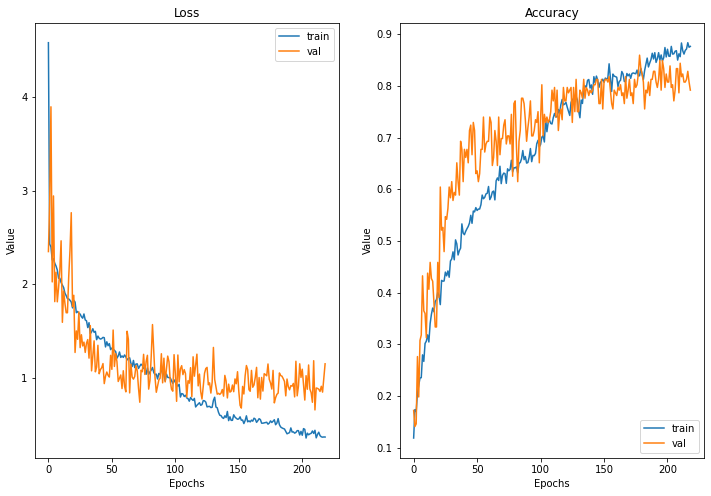

model_3
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 53ms/step - loss: 4.4909 - accuracy: 0.1173 - val_loss: 2.6523 - val_accuracy: 0.1406 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 41ms/step - loss: 2.5080 - accuracy: 0.1320 - val_loss: 2.5871 - val_accuracy: 0.1042 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 3s 44ms/step - loss: 2.4124 - accuracy: 0.1552 - val_loss: 2.6628 - val_accuracy: 0.1510 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 3s 45ms/step - loss: 2.3562 - accuracy: 0.1955 - val_loss: 2.0713 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 45ms/step - loss: 2.2820 - accuracy: 0.2093 - val_loss: 2.1044 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 3s 45ms/step - loss: 2.3009 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 40ms/step - loss: 1.3380 - accuracy: 0.5417 - val_loss: 0.7523 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2214 - accuracy: 0.5892 - val_loss: 1.0274 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2286 - accuracy: 0.5837 - val_loss: 1.0511 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 42ms/step - loss: 1.2651 - accuracy: 0.5809 - val_loss: 0.9527 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2781 - accuracy: 0.5743 - val_loss: 0.8351 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2217 - accuracy: 0.6002 - val_loss: 0.8862 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 42ms/st

57/57 [==============================] - 2s 41ms/step - loss: 0.9196 - accuracy: 0.6886 - val_loss: 0.5677 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 3s 46ms/step - loss: 0.9082 - accuracy: 0.6902 - val_loss: 0.4948 - val_accuracy: 0.8698 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9974 - accuracy: 0.6759 - val_loss: 0.6250 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9744 - accuracy: 0.6781 - val_loss: 0.9263 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9900 - accuracy: 0.6703 - val_loss: 0.8254 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9794 - accuracy: 0.6737 - val_loss: 0.5469 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 41ms/step - lo

57/57 [==============================] - 2s 41ms/step - loss: 0.7725 - accuracy: 0.7372 - val_loss: 0.7807 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 158/500
57/57 [==============================] - 2s 40ms/step - loss: 0.8088 - accuracy: 0.7355 - val_loss: 0.6602 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 159/500
57/57 [==============================] - 2s 41ms/step - loss: 0.8610 - accuracy: 0.7256 - val_loss: 0.7634 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 160/500
57/57 [==============================] - 2s 41ms/step - loss: 0.8221 - accuracy: 0.7366 - val_loss: 0.5713 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 161/500
57/57 [==============================] - 2s 42ms/step - loss: 0.7952 - accuracy: 0.7388 - val_loss: 0.5790 - val_accuracy: 0.8438 - lr: 0.0010


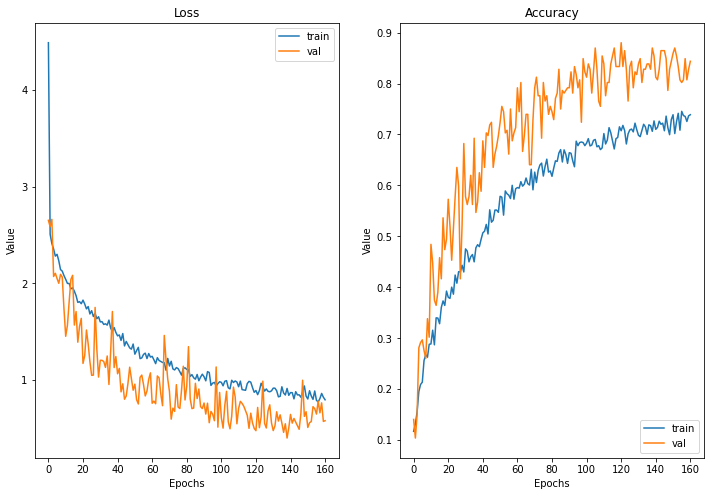

model_4
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 52ms/step - loss: 5.0822 - accuracy: 0.1096 - val_loss: 2.2927 - val_accuracy: 0.1771 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 41ms/step - loss: 2.5506 - accuracy: 0.1165 - val_loss: 3.3581 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 2s 41ms/step - loss: 2.4506 - accuracy: 0.1452 - val_loss: 3.6236 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 3s 46ms/step - loss: 2.4092 - accuracy: 0.1739 - val_loss: 2.0473 - val_accuracy: 0.3698 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 2s 41ms/step - loss: 2.2861 - accuracy: 0.2104 - val_loss: 2.6624 - val_accuracy: 0.2083 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 2s 40ms/step - loss: 2.2559 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 37ms/step - loss: 1.2566 - accuracy: 0.5820 - val_loss: 0.6872 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 40ms/step - loss: 1.3267 - accuracy: 0.5638 - val_loss: 1.0308 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2325 - accuracy: 0.5848 - val_loss: 0.8074 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 35ms/step - loss: 1.2568 - accuracy: 0.5953 - val_loss: 0.9771 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 32ms/step - loss: 1.2196 - accuracy: 0.5770 - val_loss: 0.6825 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 32ms/step - loss: 1.3095 - accuracy: 0.5748 - val_loss: 0.7478 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 32ms/st

57/57 [==============================] - 2s 35ms/step - loss: 0.9128 - accuracy: 0.7007 - val_loss: 0.5703 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 40ms/step - loss: 0.9523 - accuracy: 0.6819 - val_loss: 0.7396 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 42ms/step - loss: 0.9943 - accuracy: 0.6808 - val_loss: 0.7379 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 36ms/step - loss: 0.9293 - accuracy: 0.7018 - val_loss: 0.6132 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 33ms/step - loss: 0.9604 - accuracy: 0.6808 - val_loss: 0.7031 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 32ms/step - loss: 0.9453 - accuracy: 0.6924 - val_loss: 0.7874 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 34ms/step - lo

57/57 [==============================] - 2s 33ms/step - loss: 0.6317 - accuracy: 0.7835 - val_loss: 0.7224 - val_accuracy: 0.8021 - lr: 7.0000e-04
Epoch 157/500
57/57 [==============================] - 2s 34ms/step - loss: 0.6845 - accuracy: 0.7731 - val_loss: 0.6759 - val_accuracy: 0.8281 - lr: 7.0000e-04
Epoch 158/500
57/57 [==============================] - 2s 34ms/step - loss: 0.6790 - accuracy: 0.7819 - val_loss: 0.8248 - val_accuracy: 0.7656 - lr: 7.0000e-04
Epoch 159/500
57/57 [==============================] - 2s 33ms/step - loss: 0.5903 - accuracy: 0.7951 - val_loss: 0.9361 - val_accuracy: 0.7969 - lr: 7.0000e-04
Epoch 160/500
57/57 [==============================] - 2s 33ms/step - loss: 0.6745 - accuracy: 0.7719 - val_loss: 0.7045 - val_accuracy: 0.8281 - lr: 7.0000e-04
Epoch 161/500
57/57 [==============================] - 2s 34ms/step - loss: 0.6519 - accuracy: 0.7775 - val_loss: 0.6936 - val_accuracy: 0.8177 - lr: 7.0000e-04
Epoch 162/500
57/57 [===========================

Epoch 207/500
57/57 [==============================] - 2s 32ms/step - loss: 0.4088 - accuracy: 0.8564 - val_loss: 0.6252 - val_accuracy: 0.8490 - lr: 3.4300e-04
Epoch 208/500
57/57 [==============================] - 2s 32ms/step - loss: 0.4220 - accuracy: 0.8581 - val_loss: 0.7214 - val_accuracy: 0.8333 - lr: 3.4300e-04
Epoch 209/500
57/57 [==============================] - 2s 32ms/step - loss: 0.4322 - accuracy: 0.8592 - val_loss: 0.6396 - val_accuracy: 0.8594 - lr: 3.4300e-04
Epoch 210/500
57/57 [==============================] - 2s 32ms/step - loss: 0.3917 - accuracy: 0.8724 - val_loss: 0.7650 - val_accuracy: 0.8438 - lr: 3.4300e-04
Epoch 211/500
57/57 [==============================] - 2s 33ms/step - loss: 0.4169 - accuracy: 0.8553 - val_loss: 0.6763 - val_accuracy: 0.8490 - lr: 3.4300e-04
Epoch 212/500
57/57 [==============================] - 2s 33ms/step - loss: 0.3996 - accuracy: 0.8575 - val_loss: 0.7482 - val_accuracy: 0.8490 - lr: 3.4300e-04
Epoch 213/500
57/57 [=============

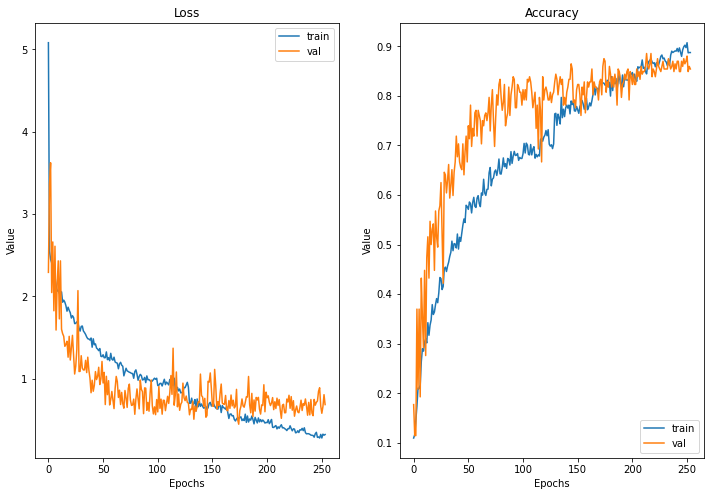

model_5
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 54ms/step - loss: 4.8269 - accuracy: 0.1064 - val_loss: 2.4722 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 3s 47ms/step - loss: 2.4329 - accuracy: 0.1590 - val_loss: 2.2675 - val_accuracy: 0.2448 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 2s 41ms/step - loss: 2.3954 - accuracy: 0.1773 - val_loss: 2.4650 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 43ms/step - loss: 2.3011 - accuracy: 0.2038 - val_loss: 2.4834 - val_accuracy: 0.1823 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 2s 35ms/step - loss: 2.2625 - accuracy: 0.2181 - val_loss: 3.2035 - val_accuracy: 0.1615 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 2s 38ms/step - loss: 2.2632 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 38ms/step - loss: 1.3410 - accuracy: 0.5494 - val_loss: 0.7966 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 33ms/step - loss: 1.2816 - accuracy: 0.5632 - val_loss: 0.9843 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 39ms/step - loss: 1.2885 - accuracy: 0.5743 - val_loss: 0.6790 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 33ms/step - loss: 1.2991 - accuracy: 0.5748 - val_loss: 1.0383 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 33ms/step - loss: 1.2566 - accuracy: 0.5754 - val_loss: 1.3550 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 32ms/step - loss: 1.2106 - accuracy: 0.6030 - val_loss: 1.0270 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 32ms/st

57/57 [==============================] - 2s 33ms/step - loss: 0.9372 - accuracy: 0.6875 - val_loss: 0.8275 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 33ms/step - loss: 0.9883 - accuracy: 0.6858 - val_loss: 0.9384 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 33ms/step - loss: 0.9465 - accuracy: 0.7024 - val_loss: 0.6368 - val_accuracy: 0.8021 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 33ms/step - loss: 0.9253 - accuracy: 0.7029 - val_loss: 0.8180 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 33ms/step - loss: 0.9376 - accuracy: 0.6963 - val_loss: 0.6270 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 36ms/step - loss: 0.8871 - accuracy: 0.6963 - val_loss: 0.5280 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 36ms/step - lo

57/57 [==============================] - 2s 33ms/step - loss: 0.8597 - accuracy: 0.7167 - val_loss: 0.7751 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 158/500
57/57 [==============================] - 2s 37ms/step - loss: 0.8574 - accuracy: 0.7206 - val_loss: 1.0094 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 159/500
57/57 [==============================] - 2s 37ms/step - loss: 0.7600 - accuracy: 0.7493 - val_loss: 0.4064 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 160/500
57/57 [==============================] - 2s 34ms/step - loss: 0.7964 - accuracy: 0.7267 - val_loss: 0.8487 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 161/500
57/57 [==============================] - 2s 32ms/step - loss: 0.8220 - accuracy: 0.7388 - val_loss: 0.4693 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 162/500
57/57 [==============================] - 2s 32ms/step - loss: 0.8492 - accuracy: 0.7327 - val_loss: 1.1492 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 163/500
57/57 [==============================] - 2s 32ms/step - lo

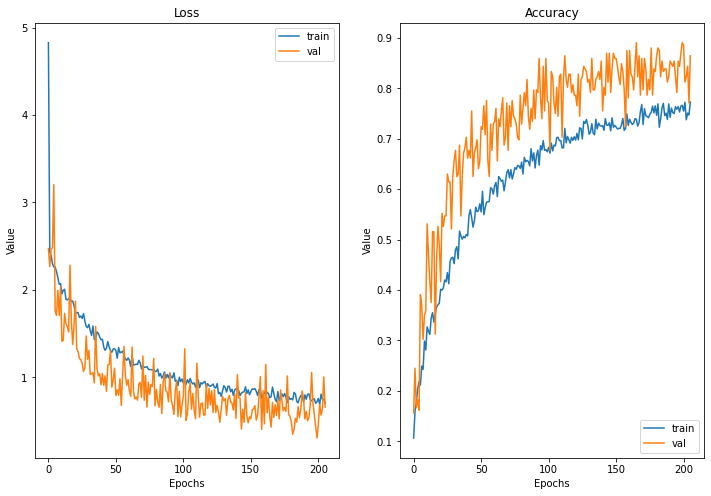

model_6
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 44ms/step - loss: 5.0765 - accuracy: 0.1113 - val_loss: 2.4342 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 33ms/step - loss: 2.5065 - accuracy: 0.1447 - val_loss: 2.9550 - val_accuracy: 0.1198 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 2s 37ms/step - loss: 2.4216 - accuracy: 0.1778 - val_loss: 2.3947 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 33ms/step - loss: 2.3432 - accuracy: 0.1806 - val_loss: 2.9779 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 2s 33ms/step - loss: 2.3114 - accuracy: 0.2076 - val_loss: 2.5529 - val_accuracy: 0.1458 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 2s 37ms/step - loss: 2.2808 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 43ms/step - loss: 1.3126 - accuracy: 0.5472 - val_loss: 0.9376 - val_accuracy: 0.6354 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 43ms/step - loss: 1.2972 - accuracy: 0.5572 - val_loss: 1.0463 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 43ms/step - loss: 1.3007 - accuracy: 0.5682 - val_loss: 1.3401 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2475 - accuracy: 0.5765 - val_loss: 0.9684 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 42ms/step - loss: 1.2405 - accuracy: 0.5864 - val_loss: 0.9920 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 43ms/step - loss: 1.2203 - accuracy: 0.6008 - val_loss: 1.2211 - val_accuracy: 0.6354 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 3s 44ms/st

57/57 [==============================] - 3s 46ms/step - loss: 0.9313 - accuracy: 0.7002 - val_loss: 0.6303 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9468 - accuracy: 0.6935 - val_loss: 0.7430 - val_accuracy: 0.8021 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9368 - accuracy: 0.6786 - val_loss: 0.6823 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 40ms/step - loss: 0.9618 - accuracy: 0.6792 - val_loss: 0.8277 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 1.0142 - accuracy: 0.6770 - val_loss: 0.7659 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9105 - accuracy: 0.7118 - val_loss: 0.6861 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 41ms/step - lo

57/57 [==============================] - 2s 41ms/step - loss: 0.6828 - accuracy: 0.7686 - val_loss: 0.6204 - val_accuracy: 0.8125 - lr: 7.0000e-04
Epoch 158/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6547 - accuracy: 0.7797 - val_loss: 0.5153 - val_accuracy: 0.8438 - lr: 7.0000e-04
Epoch 159/500
57/57 [==============================] - 2s 40ms/step - loss: 0.6531 - accuracy: 0.7962 - val_loss: 0.5394 - val_accuracy: 0.8490 - lr: 7.0000e-04
Epoch 160/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6557 - accuracy: 0.7742 - val_loss: 0.5345 - val_accuracy: 0.8438 - lr: 7.0000e-04
Epoch 161/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6548 - accuracy: 0.7846 - val_loss: 0.6525 - val_accuracy: 0.7760 - lr: 7.0000e-04
Epoch 162/500
57/57 [==============================] - 2s 41ms/step - loss: 0.6295 - accuracy: 0.7846 - val_loss: 0.6296 - val_accuracy: 0.8333 - lr: 7.0000e-04
Epoch 163/500
57/57 [===========================

Epoch 208/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5804 - accuracy: 0.8112 - val_loss: 0.6134 - val_accuracy: 0.8490 - lr: 7.0000e-04
Epoch 209/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5708 - accuracy: 0.8139 - val_loss: 0.6554 - val_accuracy: 0.8490 - lr: 7.0000e-04
Epoch 210/500
57/57 [==============================] - 2s 40ms/step - loss: 0.5814 - accuracy: 0.8095 - val_loss: 0.8669 - val_accuracy: 0.8385 - lr: 7.0000e-04
Epoch 211/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5665 - accuracy: 0.8194 - val_loss: 0.6221 - val_accuracy: 0.8750 - lr: 7.0000e-04
Epoch 212/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5923 - accuracy: 0.8106 - val_loss: 0.5775 - val_accuracy: 0.8490 - lr: 7.0000e-04
Epoch 213/500
57/57 [==============================] - 2s 41ms/step - loss: 0.5616 - accuracy: 0.8089 - val_loss: 0.5444 - val_accuracy: 0.8646 - lr: 4.9000e-04
Epoch 214/500
57/57 [=============

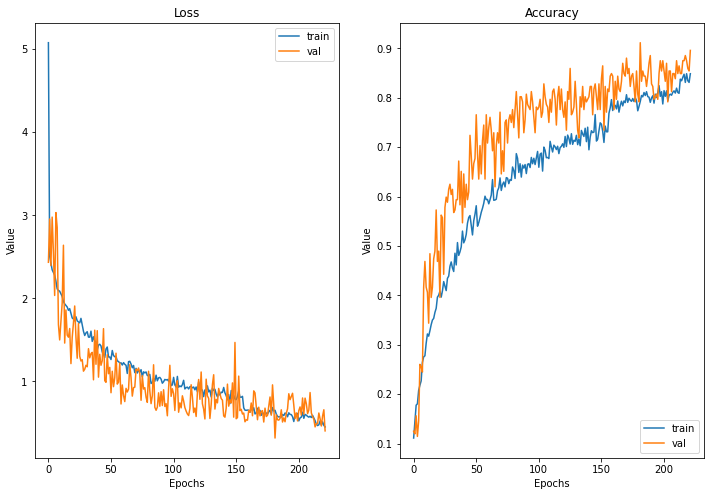

model_7
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 53ms/step - loss: 4.6594 - accuracy: 0.1212 - val_loss: 2.2471 - val_accuracy: 0.1458 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 3s 44ms/step - loss: 2.5097 - accuracy: 0.1425 - val_loss: 2.3468 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 3s 46ms/step - loss: 2.4230 - accuracy: 0.1518 - val_loss: 2.3835 - val_accuracy: 0.1771 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 42ms/step - loss: 2.3586 - accuracy: 0.1866 - val_loss: 3.1217 - val_accuracy: 0.1406 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 3s 46ms/step - loss: 2.3054 - accuracy: 0.1988 - val_loss: 2.4760 - val_accuracy: 0.1927 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 2s 41ms/step - loss: 2.2432 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3757 - accuracy: 0.5257 - val_loss: 0.7645 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 41ms/step - loss: 1.3164 - accuracy: 0.5583 - val_loss: 0.8066 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 3s 46ms/step - loss: 1.2795 - accuracy: 0.5649 - val_loss: 0.6358 - val_accuracy: 0.8021 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2804 - accuracy: 0.5516 - val_loss: 1.9064 - val_accuracy: 0.5365 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2838 - accuracy: 0.5693 - val_loss: 0.9600 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2784 - accuracy: 0.5721 - val_loss: 1.2048 - val_accuracy: 0.6146 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 42ms/st

57/57 [==============================] - 2s 41ms/step - loss: 0.9972 - accuracy: 0.6670 - val_loss: 0.6146 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 40ms/step - loss: 0.9810 - accuracy: 0.6781 - val_loss: 0.7286 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9707 - accuracy: 0.6858 - val_loss: 0.4674 - val_accuracy: 0.8698 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9553 - accuracy: 0.6902 - val_loss: 0.5926 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9119 - accuracy: 0.6969 - val_loss: 0.6378 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9719 - accuracy: 0.6913 - val_loss: 0.7609 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 40ms/step - lo

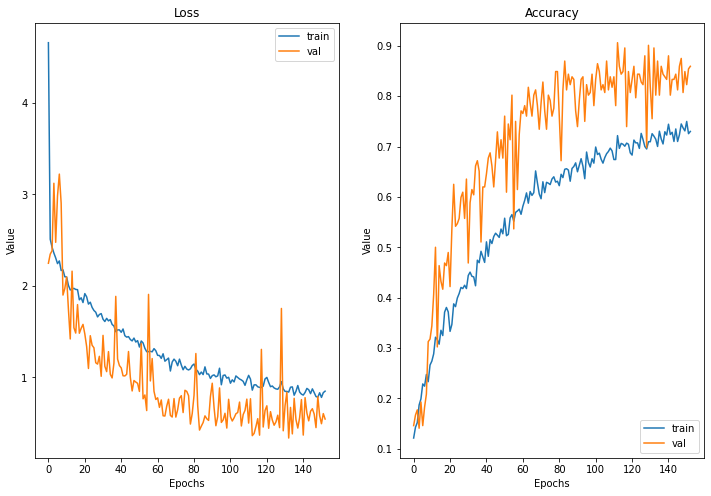

model_8
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 3s 55ms/step - loss: 4.7258 - accuracy: 0.1228 - val_loss: 2.4069 - val_accuracy: 0.1823 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 42ms/step - loss: 2.4975 - accuracy: 0.1606 - val_loss: 3.8228 - val_accuracy: 0.1094 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 2s 41ms/step - loss: 2.3809 - accuracy: 0.1722 - val_loss: 5.1943 - val_accuracy: 0.1042 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 41ms/step - loss: 2.4205 - accuracy: 0.1827 - val_loss: 3.0260 - val_accuracy: 0.1094 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 2s 41ms/step - loss: 2.2414 - accuracy: 0.2185 - val_loss: 2.6732 - val_accuracy: 0.1354 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 2s 41ms/step - loss: 2.2252 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2227 - accuracy: 0.5905 - val_loss: 0.8236 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2726 - accuracy: 0.5778 - val_loss: 1.1816 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2976 - accuracy: 0.5712 - val_loss: 0.8150 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2327 - accuracy: 0.5927 - val_loss: 1.3479 - val_accuracy: 0.6302 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 41ms/step - loss: 1.2525 - accuracy: 0.5778 - val_loss: 1.4987 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 40ms/step - loss: 1.2407 - accuracy: 0.5773 - val_loss: 0.7047 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 42ms/st

57/57 [==============================] - 3s 46ms/step - loss: 0.9028 - accuracy: 0.6970 - val_loss: 0.5892 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 106/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9386 - accuracy: 0.6893 - val_loss: 1.0194 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 107/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9095 - accuracy: 0.7025 - val_loss: 0.7975 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 108/500
57/57 [==============================] - 2s 41ms/step - loss: 0.9301 - accuracy: 0.6926 - val_loss: 0.8324 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 109/500
57/57 [==============================] - 3s 46ms/step - loss: 0.8950 - accuracy: 0.6909 - val_loss: 0.4492 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 110/500
57/57 [==============================] - 2s 41ms/step - loss: 0.8984 - accuracy: 0.7036 - val_loss: 0.5291 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 111/500
57/57 [==============================] - 2s 41ms/step - lo

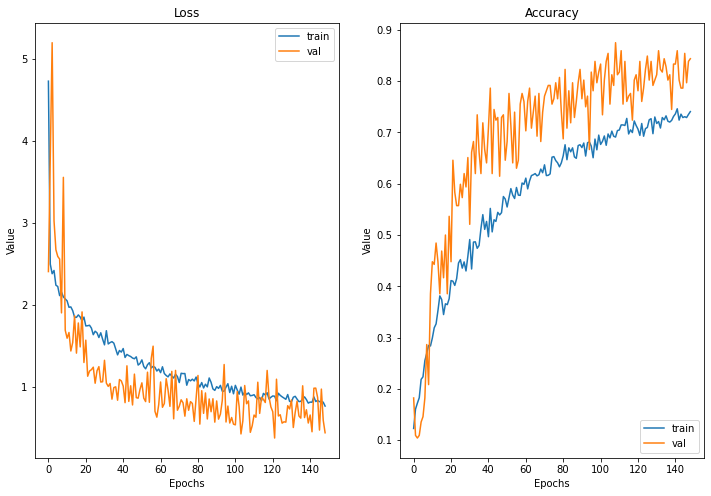

model_9
-------------------------------------------------------------------------------------------------------------------------
Epoch 1/500
57/57 [==============================] - 2s 42ms/step - loss: 5.0594 - accuracy: 0.1009 - val_loss: 2.8970 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 2s 37ms/step - loss: 2.4958 - accuracy: 0.1446 - val_loss: 2.8116 - val_accuracy: 0.1458 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 2s 33ms/step - loss: 2.4385 - accuracy: 0.1650 - val_loss: 3.5735 - val_accuracy: 0.1354 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 2s 33ms/step - loss: 2.3817 - accuracy: 0.1656 - val_loss: 3.0740 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 2s 36ms/step - loss: 2.2892 - accuracy: 0.1959 - val_loss: 2.1528 - val_accuracy: 0.3021 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 2s 32ms/step - loss: 2.1936 - accuracy: 0.

Epoch 53/500
57/57 [==============================] - 2s 32ms/step - loss: 1.2126 - accuracy: 0.5911 - val_loss: 1.0645 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 54/500
57/57 [==============================] - 2s 32ms/step - loss: 1.2588 - accuracy: 0.5889 - val_loss: 0.7979 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 55/500
57/57 [==============================] - 2s 32ms/step - loss: 1.2325 - accuracy: 0.6015 - val_loss: 1.1518 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 56/500
57/57 [==============================] - 2s 32ms/step - loss: 1.3236 - accuracy: 0.5701 - val_loss: 1.0058 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 57/500
57/57 [==============================] - 2s 32ms/step - loss: 1.2173 - accuracy: 0.5993 - val_loss: 1.1637 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 58/500
57/57 [==============================] - 2s 32ms/step - loss: 1.1800 - accuracy: 0.6076 - val_loss: 0.8328 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 59/500
57/57 [==============================] - 2s 32ms/st

57/57 [==============================] - 2s 32ms/step - loss: 0.7324 - accuracy: 0.7517 - val_loss: 0.8490 - val_accuracy: 0.7552 - lr: 7.0000e-04
Epoch 106/500
57/57 [==============================] - 2s 32ms/step - loss: 0.8291 - accuracy: 0.7246 - val_loss: 0.7850 - val_accuracy: 0.7917 - lr: 7.0000e-04
Epoch 107/500
57/57 [==============================] - 2s 32ms/step - loss: 0.7350 - accuracy: 0.7528 - val_loss: 0.7482 - val_accuracy: 0.8021 - lr: 7.0000e-04
Epoch 108/500
57/57 [==============================] - 2s 32ms/step - loss: 0.7962 - accuracy: 0.7208 - val_loss: 0.7546 - val_accuracy: 0.8073 - lr: 7.0000e-04
Epoch 109/500
57/57 [==============================] - 2s 32ms/step - loss: 0.7540 - accuracy: 0.7357 - val_loss: 0.8136 - val_accuracy: 0.8125 - lr: 7.0000e-04
Epoch 110/500
57/57 [==============================] - 2s 32ms/step - loss: 0.7893 - accuracy: 0.7384 - val_loss: 0.6384 - val_accuracy: 0.8177 - lr: 7.0000e-04
Epoch 111/500
57/57 [===========================

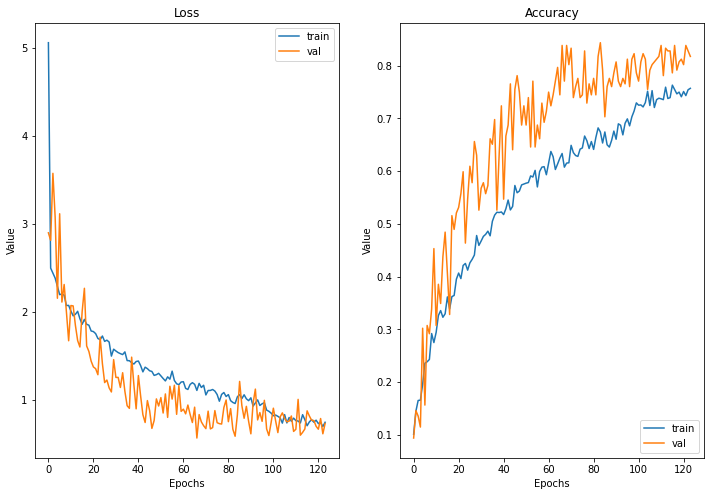

In [36]:
i = 0
for train_idx, valid_idx in sk_fold.split(X_trains, y_trains.argmax(1)):
# for train_idx, valid_idx in k_fold.split(X_trains, y_trains.argmax(1)):
    print("model_{}".format(i))
    print("-------------------------------------------------------------------------------------------------------------------------")
    X_train, y_train = X_trains[train_idx], y_trains[train_idx]
    X_valid, y_valid = X_trains[valid_idx], y_trains[valid_idx]
#     X_train = X_train/255.0
#     X_valid = X_valid/255.0
    # callback
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        "model/deskewed_skfold{}.h5".format(i), save_best_only=True, monitor='val_accuracy', mode='auto')
    
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=30)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 40, restore_best_weights = True)
    
    # model
    model = None
    model = rexnet()
    
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=Adam(
    lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics=['accuracy'])
    
    # train
    history = model.fit(datagen.flow(X_train, y_train, shuffle=True, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=valid_datagen.flow(X_valid, y_valid),
                        verbose=1,
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_steps=X_valid.shape[0] //batch_size,
                        callbacks=[checkpoint_cb, early_stopping, lr_scheduler]
                                  )
    # graph
    plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
    
    i += 1

In [37]:
# for idx in range(num_model):
#     print("model_{}".format(idx+1))
#     print("-------------------------------------------------------------------------------------------------------------------------")
#     X_train, X_valid, y_train, y_valid = train_test_split(X_trains, y_trains, test_size=0.2, stratify=train['digit'])
#     X_train = X_train/255.0
#     X_valid = X_valid/255.0
    
#     model = None
#     model = rexnet()
    
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(
#     lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics=['accuracy'])
    
#     checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
#         "model/deskewed_onehot_{}.h5".format(idx), save_best_only=True, monitor='val_accuracy', mode='auto')
    
#     lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', factor=0.7, patience=30)
    
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 40, restore_best_weights = True)
    
#     history = model.fit(datagen.flow(X_train, y_train, shuffle=True, batch_size=batch_size),
#                                   epochs=epochs, validation_data=(
#                                       X_valid, y_valid),
#                                   verbose=1,
#                                  steps_per_epoch=X_train.shape[0] // batch_size,
#                                   validation_steps=X_valid.shape[0] //batch_size,
#                                   callbacks=[checkpoint_cb, early_stopping, lr_scheduler]
#                                   )
#     plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

## Predict

In [38]:
X_test = X_test/255.0

In [39]:
best_model_list = []
for i in range(10):
    best = tf.keras.models.load_model('model/deskewed_skfold{}.h5'.format(i))
    best_model_list.append(best)

In [40]:
result_list = []
X_valids = X_valid/255.0

for idx, model in enumerate(best_model_list):
    result = model.evaluate(X_valids, y_valid)
    print("model_{}_acc : {}".format(idx+1, result))

7/7 [==============================] - 20s 3s/step - loss: 0.3176 - accuracy: 0.8971
model_1_acc : [0.31762200593948364, 0.8970588445663452]
7/7 [==============================] - 0s 8ms/step - loss: 0.5341 - accuracy: 0.8284
model_2_acc : [0.5341284871101379, 0.8284313678741455]
7/7 [==============================] - 0s 8ms/step - loss: 0.0980 - accuracy: 0.9657
model_3_acc : [0.09802330285310745, 0.9656862616539001]
7/7 [==============================] - 0s 9ms/step - loss: 0.4624 - accuracy: 0.8775
model_4_acc : [0.4624063968658447, 0.8774510025978088]
7/7 [==============================] - 0s 9ms/step - loss: 0.0890 - accuracy: 0.9706
model_5_acc : [0.08896655589342117, 0.970588207244873]
7/7 [==============================] - 0s 12ms/step - loss: 0.2613 - accuracy: 0.9020
model_6_acc : [0.2612529397010803, 0.9019607901573181]
7/7 [==============================] - 0s 11ms/step - loss: 0.1208 - accuracy: 0.9559
model_7_acc : [0.1208413690328598, 0.9558823704719543]
7/7 [===========

In [41]:
pred_list = []
for idx, model in enumerate(best_model_list):
    pred = model.predict(X_test)
    pred_list.append(pred)

In [42]:
final_pred = np.array([0]*204800).reshape(20480, 10).astype('float64')
for pred in pred_list:
    final_pred += pred
final_pred = np.argmax(final_pred, axis=1)

In [43]:
final_pred

array([6, 9, 8, ..., 6, 3, 0])

In [44]:
submission['digit'] = final_pred

In [45]:
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,3


In [46]:
submission.to_csv('./submission/deskewed_skfold_submission.csv', index=False)